In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [12]:
rs=121
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

In [4]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/stock_hmm_output.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Return','Volatility','HighR','LowR']
target='State'
#train, test = train_test_split(data,test_size=0.2,shuffle=True,random_state=rs,stratify=data['State'])

In [5]:
#With TimeSeries
#First Set Aside Testing data
final_test=[]
l=[]
ft_size=400
for x in data.groupby(['Ticker']):
    final_test.append(x[1][-ft_size:])
    l.append(x[1][:-ft_size])
#Model Training
#model=
#model.fit(x=train_x,y=train_y)
#Model Prediction and Accuracy
#accuracy_score(test_y,model.predict(test_x))


In [6]:
def createSlidingWindow(tr,te,f,t, window=7):
    splitting=SlidingWindowSplitter(window_length=window,step_length=1,fh=[1])
    train_x=[]
    train_y=[]
    test_x=[]
    test_y=[]
    
    for i in splitting.split(tr):
        train_x.append(tr.iloc[i[0]][f].values.flatten())
        train_y.append(tr.iloc[i[1]][t].values.flatten()[0])
    
    for i in splitting.split(te):
        test_x.append(te.iloc[i[0]][f].values.flatten())
        test_y.append(te.iloc[i[1]][t].values.flatten()[0])
    return ((train_x,train_y),(test_x,test_y))

In [7]:
testing_size=500
ns=5
tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
training_list=[]
testing_list=[]
for i in range(ns):
    training_list.append([[],[]])
    testing_list.append([[],[]])
training_lists = {}
testing_lists = {}
for spread in range(2,25):
    for x in l:
        for (i,t) in enumerate(tss.split(x)):
            ((train_x,train_y),(test_x,test_y))=createSlidingWindow(x.iloc[t[0]],x.iloc[t[1]],features,target, window = spread)
            training_list[i][0] += train_x
            training_list[i][1] += train_y
            testing_list[i][0] += test_x
            testing_list[i][1] += test_y
    training_lists[spread] = training_list
    testing_lists[spread] = testing_list
    training_list=[]
    testing_list=[]
    for i in range(ns):
        training_list.append([[],[]])
        testing_list.append([[],[]])


In [ ]:
with open('saved_training_lists.pkl', 'wb') as f:
    pickle.dump(training_lists, f)

with open('saved_testing_lists.pkl', 'wb') as f:
    pickle.dump(testing_lists, f)

In [5]:
#load training, test windows here, they're saved for complexity reasons, run code from here
with open('saved_training_lists.pkl', 'rb') as f:
    training_lists = pickle.load(f)

with open('saved_testing_lists.pkl', 'rb') as f:
    testing_lists = pickle.load(f)

In [8]:
model = XGBClassifier(tree_method="hist", device="cuda") 
accuracies_xgb = {}
for window in training_lists.keys():
    training_list = training_lists[window]
    testing_list = testing_lists[window]
    a=0 
    for i in range(ns):
        model.fit(X=training_list[i][0],y=training_list[i][1])
        a+= accuracy_score(model.predict(testing_list[i][0]),testing_list[i][1])
    a=a/ns
    accuracies_xgb[window] = a

c:\Users\18585\anaconda3\envs\erdos_spring_2025\Lib\site-packages\xgboost\core.py:729: UserWarning: [00:13:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


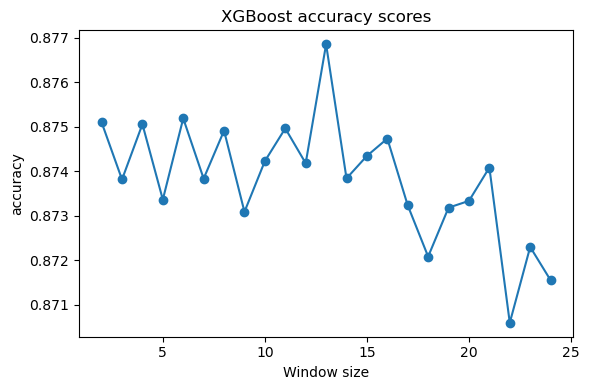

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(list(accuracies_xgb.keys()), list(accuracies_xgb.values()), marker='o')
plt.title("XGBoost accuracy scores")
plt.xlabel("Window size")
plt.ylabel("accuracy")
plt.tight_layout()
plt.show()

In [14]:
model_names=['ada','decisiontree']
training_list  = training_lists[13]
testing_list = testing_lists[13]
accuracies=[]
models=[AdaBoostClassifier(n_estimators=100,random_state=121),DecisionTreeClassifier(random_state=rs)]
#Add Possible AdaBoostModels:
for m in models:
    a=0
    for i in range(ns):
        m.fit(X=training_list[i][0],y=training_list[i][1])
        a+= accuracy_score(m.predict(testing_list[i][0]),testing_list[i][1])
    a=a/ns
    accuracies.append(a)

In [15]:
#Naive prediction
a=0
for i in range(ns):
    a+=accuracy_score([1]*len(testing_list[i][1]),testing_list[i][1])
a=a/ns
print(a)

0.7700205338809034


In [16]:
accuracies

[0.8726899383983573, 0.8026400704018772]